## Hierarchical Modelling in Stan: Predicting the Premier League
* https://www.youtube.com/watch?v=dNZQrcAjgXQ&list=PLCrWEzJgSUqwL85xIj1wubGdY15C5Gf7H&index=7
* https://github.com/MaggieLieu/STAN_tutorials/tree/master/Hierarchical

In [73]:
#!wget https://raw.githubusercontent.com/MaggieLieu/STAN_tutorials/master/Hierarchical/premiereleague.csv

--2024-04-07 14:50:53--  https://raw.githubusercontent.com/MaggieLieu/STAN_tutorials/master/Hierarchical/premiereleague.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13021 (13K) [text/plain]
Saving to: ‘premiereleague.csv.5’

premiereleague.csv. 100%[===================>]  12.72K  --.-KB/s    in 0.003s  

2024-04-07 14:50:53 (4.86 MB/s) - ‘premiereleague.csv.5’ saved [13021/13021]



In [74]:
import numpy as np

import stan
import arviz as az
import nest_asyncio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
nest_asyncio.apply()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
data = pd.read_csv("premiereleague.csv", header=None)

In [76]:
data.head()

,0,1,2,3
0,Liverpool,4,1,Norwich City
1,West Ham United,0,5,Manchester City
2,Burnley,3,0,Southampton
3,Crystal Palace,0,0,Everton
4,Watford,0,3,Brighton & Hove Albion


In [77]:
data.columns = ["home", "home score", "away score", "away"]

In [78]:
data.head()

,home,home score,away score,away
0,Liverpool,4,1,Norwich City
1,West Ham United,0,5,Manchester City
2,Burnley,3,0,Southampton
3,Crystal Palace,0,0,Everton
4,Watford,0,3,Brighton & Hove Albion


In [79]:
ng = data.shape[0]
print(ng)

329


In [80]:
nt = len(data["home"].unique())
print(nt)

20


### Traditional model
* We will assume that the goals scored come from a poisson distribution
$$s1 | \theta_{g1} \sim Poisson(\theta_{g1}) $$
$$s2 | \theta_{g2} \sim Poisson(\theta_{g2}) $$

* Assuming a log-linear random effect model
$$ log(\theta_{g1}) = home + att_ht + def_at$$
$$ log(\theta_{g2}) = att_at + def_ht $$

* where home is a constant for the advantage for the team hosting the game
* att and def are the attack and defence abilities of the teams where the indices at,ht correspond to the t=1-20 teams. 

* priors we willl use for the attack and defence abilities are very wide, essentially the teams' performances are independent of each other
$$home \sim normal(0,0.0001)$$
$$att[t] ~ normal(0, 2)$$
$$def[t] ~ normal(0, 2)$$

* Now convert team names for each match into numbers

In [81]:
teams = data["home"].unique()
print(teams)

['Liverpool' 'West Ham United' 'Burnley' 'Crystal Palace' 'Watford'
 'AFC Bournemouth' 'Tottenham Hotspur' 'Leicester City' 'Newcastle United'
 'Manchester United' 'Arsenal' 'Aston Villa' 'Everton' 'Norwich City'
 'Southampton' 'Brighton & Hove Albion' 'Manchester City'
 'Sheffield United' 'Chelsea' 'Wolverhampton Wanderers']


In [82]:
teams_id = {team: i + 1 for i, team in enumerate(teams)}
teams_id

{'Liverpool': 1,
 'West Ham United': 2,
 'Burnley': 3,
 'Crystal Palace': 4,
 'Watford': 5,
 'AFC Bournemouth': 6,
 'Tottenham Hotspur': 7,
 'Leicester City': 8,
 'Newcastle United': 9,
 'Manchester United': 10,
 'Arsenal': 11,
 'Aston Villa': 12,
 'Everton': 13,
 'Norwich City': 14,
 'Southampton': 15,
 'Brighton & Hove Albion': 16,
 'Manchester City': 17,
 'Sheffield United': 18,
 'Chelsea': 19,
 'Wolverhampton Wanderers': 20}

In [83]:
data["home_id"] = data["home"].apply(lambda x: teams_id[x])
data["away_id"] = data["away"].apply(lambda x: teams_id[x])
data.head()

,home,home score,away score,away,home_id,away_id
0,Liverpool,4,1,Norwich City,1,14
1,West Ham United,0,5,Manchester City,2,17
2,Burnley,3,0,Southampton,3,15
3,Crystal Palace,0,0,Everton,4,13
4,Watford,0,3,Brighton & Hove Albion,5,16


In [84]:
ht = data["home_id"].values
at = data["away_id"].values

In [85]:
np = 5  # game for prediction
ngob = ng - np

In [86]:
ng, np, ngob

(329, 5, 324)

In [87]:
len(ht[:ngob])

324

In [88]:
len(ht[ngob:])

5

In [89]:
data_stan = {
    "nt": nt,
    "ng": ngob,
    "np": np,
    "ht": ht[:ngob],
    "at": at[:ngob],
    "s1": data["home score"].values[:ngob],
    "s2": data["away score"].values[:ngob],
    "htnew": ht[ngob:],
    "atnew": at[ngob:],
}

In [90]:
nonhier_mode = """
data {
  int<lower=0> nt; //number of teams
  int<lower=0> ng; //number of games
  array[ng] int<lower=0> ht; //home team index
  array[ng] int<lower=0> at; //away team index
  array[ng] int<lower=0> s1; //score home team
  array[ng] int<lower=0> s2; //score away team
  int<lower=0> np; //number of predicted games
  array[np] int<lower=0> htnew; //home team index for prediction
  array[np] int<lower=0> atnew; //away team index for prediction
}

parameters {
  real home; //home advantage
  vector[nt] att; //attack ability of each team
  vector[nt] def; //defence ability of each team
}

transformed parameters {
  vector[ng] theta1; //score probability of home team
  vector[ng] theta2; //score probability of away team

  theta1 = exp(home + att[ht] - def[at]);
  theta2 = exp(att[at] - def[ht]);
}

model {
//priors
  att ~ normal(0, 2);
  def ~ normal(0, 2);
  home ~ normal(0,0.0001);

//likelihood
  s1 ~ poisson(theta1);
  s2 ~ poisson(theta2);
}

generated quantities {
//generate predictions
  vector[np] theta1new; //score probability of home team
  vector[np] theta2new; //score probability of away team
  array[np] int<lower=0> s1new; //predicted score
  array[np] int<lower=0> s2new; //predicted score

  theta1new = exp(home + att[htnew] - def[atnew]);
  theta2new = exp(att[atnew] - def[htnew]);
  s1new = poisson_rng(theta1new);
  s2new = poisson_rng(theta2new);
}
"""

In [91]:
nonhier_model = stan.build(nonhier_mode, data=data_stan)

Building...


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_6ofz2jc7/model_yqxsxof6.stan', line 32, column 18: Argument
    0.0001 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [92]:
nonhier_posterior = nonhier_model.sample(num_chains=4, num_samples=1000)

Sampling:   0%


Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  56% (4500/8000)
Sampling:  71% (5700/8000)
Sampling:  85% (6800/

In [93]:
az.summary(nonhier_posterior, var_names=["home", "att", "def"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
home,-0.000,0.000,-0.000,0.000,0.000,0.000,3969.0,2542.0,1.00
att[0],0.693,0.329,0.099,1.310,0.071,0.055,22.0,42.0,1.14
att[1],0.130,0.347,-0.502,0.776,0.072,0.051,23.0,52.0,1.13
att[2],0.028,0.348,-0.616,0.671,0.072,0.051,24.0,49.0,1.13
att[3],-0.253,0.358,-0.889,0.454,0.069,0.049,27.0,59.0,1.11
att[4],-0.163,0.357,-0.851,0.482,0.069,0.050,27.0,69.0,1.11
att[5],-0.095,0.352,-0.770,0.535,0.069,0.050,26.0,45.0,1.12
att[6],0.388,0.331,-0.193,1.013,0.070,0.056,23.0,45.0,1.13
att[7],0.546,0.333,-0.083,1.150,0.072,0.055,22.0,49.0,1.13
att[8],-0.059,0.351,-0.709,0.575,0.069,0.049,26.0,74.0,1.12


In [94]:
nonhier_posterior

<stan.Fit>
Parameters:
    home: ()
    att: (20,)
    def: (20,)
    theta1: (324,)
    theta2: (324,)
    theta1new: (5,)
    theta2new: (5,)
    s1new: (5,)
    s2new: (5,)
Draws: 4000

In [97]:
pred_score = [
    nonhier_posterior["s1new"].mean(axis=1),
    nonhier_posterior["s2new"].mean(axis=1),
]

In [98]:
pred_score

[array([1.96225, 0.809  , 1.2475 , 3.01975, 0.9825 ]),
 array([0.9505 , 1.039  , 1.28625, 0.68   , 3.30875])]

In [99]:
true_score = [data["home score"].values[ngob:], data["away score"].values[ngob:]]

In [100]:
true_score

[array([3, 1, 2, 2, 1]), array([0, 1, 2, 0, 0])]

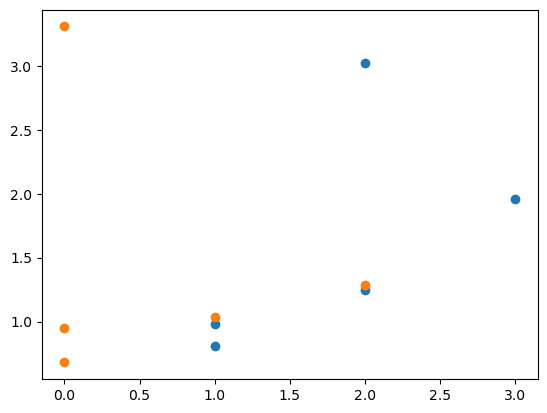

In [103]:
plt.plot(true_score[0], pred_score[0], "o", label="home")
plt.plot(true_score[1], pred_score[1], "o", label="away")

In [116]:
att = nonhier_posterior["att"].mean(axis=1)
def_ = nonhier_posterior["def"].mean(axis=1)

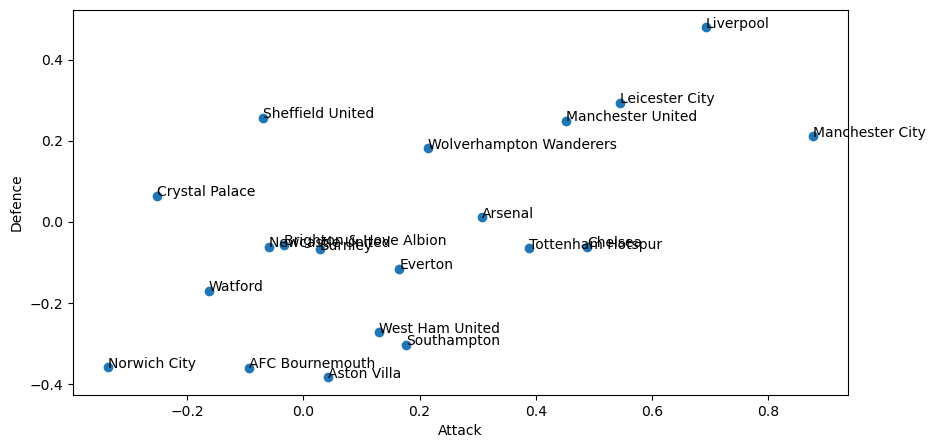

In [119]:
plt.figure(figsize=(10, 5))
plt.plot(att, def_, "o")
plt.xlabel("Attack")
plt.ylabel("Defence")
for i, team in enumerate(teams):
    plt.text(att[i], def_[i], team)
# plt.text(att[0], def_[0], "start")

array([[<Axes: title={'center': 'home'}>,
        <Axes: title={'center': 'home'}>],
       [<Axes: title={'center': 'att'}>, <Axes: title={'center': 'att'}>],
       [<Axes: title={'center': 'def'}>, <Axes: title={'center': 'def'}>]],
      dtype=object)

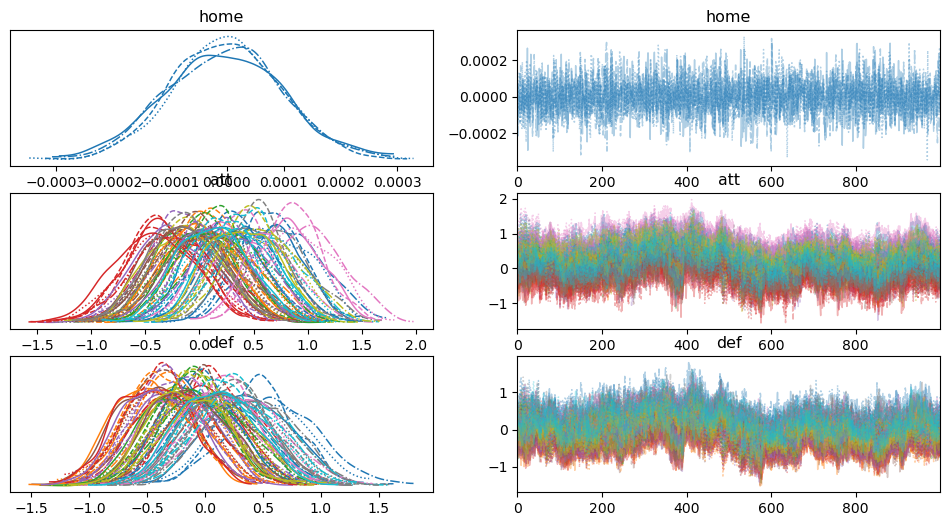

In [124]:
az.plot_trace(nonhier_posterior, var_names=["home", "att", "def"])

In [ ]:
# TODO: hierarchical model

In [115]:
nonhier_posterior["def"].mean(axis=1)

array([ 0.47977323, -0.27296659, -0.06795063,  0.06427867, -0.17127222,
       -0.36019887, -0.06569451,  0.2932439 , -0.06221583,  0.24868599,
        0.01068713, -0.3835919 , -0.11593322, -0.35942055, -0.30448285,
       -0.05724009,  0.21075933,  0.25578494, -0.06265151,  0.1810726 ])

In [111]:
nonhier_posterior

<stan.Fit>
Parameters:
    home: ()
    att: (20,)
    def: (20,)
    theta1: (324,)
    theta2: (324,)
    theta1new: (5,)
    theta2new: (5,)
    s1new: (5,)
    s2new: (5,)
Draws: 4000